# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


c:\Users\Paul\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']] 
          # single bracket will say row,column, but double brackets will point at rows and then a list of columns
          # without that, we'll use row,column by default
          )
df = df.merge(cat_df, on = 'ticker', how = 'left') # doing left join just like in sql, df is left side, cat_df is the right side

In [3]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category
0,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,15.17,N,
1,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,15.01,N,
2,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,15.00,N,
3,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,14.86,N,
4,ACN,2001-07-26,14.95,14.99,14.50,14.50,10.900705,6335300.0,ACN.csv,2001,14.95,N,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321531,ZIXI,2005-06-27,3.15,3.15,3.03,3.04,3.040000,182500.0,ZIXI.csv,2005,3.08,Q,Q
321532,ZIXI,2005-06-28,3.12,3.12,3.04,3.06,3.060000,120800.0,ZIXI.csv,2005,3.04,Q,Q
321533,ZIXI,2005-06-29,3.09,3.24,3.02,3.12,3.120000,326200.0,ZIXI.csv,2005,3.06,Q,Q
321534,ZIXI,2005-06-30,3.15,3.18,3.09,3.13,3.130000,48000.0,ZIXI.csv,2005,3.12,Q,Q


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [4]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [ ]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True) # drop anything that doesn't have a target value
    .dropna(subset = ['target'])
    )
df

C:\Users\Paul\AppData\Local\Temp\ipykernel_34884\1946656050.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.assign(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,15.17,N,,-0.010547,0.0,0.25,-0.04,0.0
1,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,15.01,N,,-0.000666,0.0,0.46,0.00,0.0
2,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,15.00,N,,-0.009333,0.0,0.27,-0.09,1.0
3,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,14.86,N,,0.006057,1.0,0.30,0.25,0.0
4,ACN,2001-07-26,14.95,14.99,14.50,14.50,10.900705,6335300.0,ACN.csv,2001,14.95,N,,-0.030100,0.0,0.49,-0.45,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321530,ZIXI,2005-06-24,3.09,3.12,3.04,3.08,3.080000,782200.0,ZIXI.csv,2005,3.06,Q,Q,0.006536,1.0,0.08,-0.01,0.0
321531,ZIXI,2005-06-27,3.15,3.15,3.03,3.04,3.040000,182500.0,ZIXI.csv,2005,3.08,Q,Q,-0.012987,0.0,0.12,-0.11,1.0
321532,ZIXI,2005-06-28,3.12,3.12,3.04,3.06,3.060000,120800.0,ZIXI.csv,2005,3.04,Q,Q,0.006579,1.0,0.08,-0.06,1.0
321533,ZIXI,2005-06-29,3.09,3.24,3.02,3.12,3.120000,326200.0,ZIXI.csv,2005,3.06,Q,Q,0.019608,1.0,0.22,0.03,1.0


In [ ]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit

StandardScaler()

In [9]:
# Transform the returns data using the fitted scaler

returns = df.returns.values.reshape(-1, 1)
scaled_returns_np = std_scaler.transform(df.returns.values.reshape(-1, 1))
scaled_returns = pd.DataFrame(scaled_returns_np, columns=['returns'])
scaled_returns.describe()

,returns
count,3.214460e+05
mean,-1.034770e-18
std,1.000002e+00
min,-1.570659e+00
25%,-1.894391e-02
50%,-3.667276e-03
75%,1.147900e-02
max,5.234901e+02


In [10]:
df.returns.describe()

count    321446.000000
mean          0.002328
std           0.634838
min          -0.994785
25%          -0.009698
50%           0.000000
75%           0.009615
max         332.333320
Name: returns, dtype: float64

###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

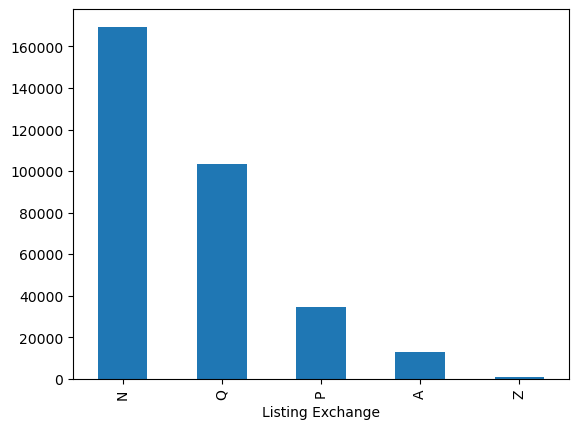

In [11]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['Listing Exchange']])

OneHotEncoder()

In [13]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [15]:
listing_enc

<321446x5 sparse matrix of type '<class 'numpy.float64'>'
	with 321446 stored elements in Compressed Sparse Row format>

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [17]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [18]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [19]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [22]:
Y_proba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [23]:
Y_pred_train
Y_proba_train

array([[0.53792977, 0.46207023],
       [0.53792977, 0.46207023],
       [0.53792977, 0.46207023],
       ...,
       [0.53792977, 0.46207023],
       [0.53792977, 0.46207023],
       [0.53792977, 0.46207023]])

In [25]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_proba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5455015632534337,
 'accuracy_score_test': 0.5446414683465547,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'log_loss_train': 0.6877685737784315,
 'log_loss_test': 0.6876530607595036,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [26]:
from sklearn.compose import ColumnTransformer

In [ ]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop' # can also use passthrough
)
# anorther option is raise an error

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric_transfomer',
                                                  StandardScaler(),
                                                  ['returns', 'Volume', 'op_cl',
                                                   'hi_lo']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Listing Exchange',
                                                   'Market Category'])])),
                ('decisiontree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [29]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [30]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [ ]:
# Evaluate hyperparameter configuration 2,
# running the pipeline
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6792923674925965,
 'log_loss_test': 0.6792776430688804,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'f1_score_train': 0.0,
 'f1_score_test': 0.0,
 'accuracy_score_train': 0.5466401586591745,
 'accuracy_score_test': 0.5409472701819878}

In [33]:
pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('numeric_transfomer', StandardScaler(),
                                    ['returns', 'Volume', 'op_cl', 'hi_lo']),
                                   ('onehot',
                                    OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                    ['Listing Exchange', 'Market Category'])])),
  ('decisiontree', DecisionTreeClassifier(criterion='entropy', max_depth=15))],
 'transform_input': None,
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('numeric_transfomer', StandardScaler(),
                                  ['returns', 'Volume', 'op_cl', 'hi_lo']),
                                 ('onehot',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                  ['Listing Exchange', 'Market Category'])]),
 'decisiontree': DecisionTreeClassifier(criterion='entropy', max_depth=15),
 'preproc__force_in

In [ ]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15}) # ** will unpack the dictionary, helps change params on the fly
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6352809338339869,
 'log_loss_test': 1.4119088751034388,
 'cohen_kappa_train': np.float64(0.1576203044804685),
 'cohen_kappa_test': np.float64(0.07390928688434473),
 'f1_score_train': 0.5097828473690902,
 'f1_score_test': 0.46525237746891,
 'accuracy_score_train': 0.5876222511714725,
 'accuracy_score_test': 0.5451858764971225}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [34]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [35]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.778633,0.097804,0.544564,0.587752,0.440067,0.498771,0.498938,0.557669,0.393623,0.451125,0.552542,0.636227,-1.443768,-0.637092,-0.257339,-0.227146
1,1.748484,0.109202,0.527820,0.586712,0.441698,0.521787,0.477607,0.550521,0.410811,0.495903,0.532321,0.636184,-2.339399,-0.636801,-0.274419,-0.227027
2,1.767808,0.088576,0.542768,0.585148,0.483818,0.487485,0.497023,0.556121,0.471297,0.433930,0.554337,0.631448,-1.517403,-0.639251,-0.258354,-0.228029
3,1.737574,0.087710,0.533248,0.592335,0.363355,0.457993,0.478300,0.579011,0.292952,0.378817,0.543788,0.642152,-1.739882,-0.634835,-0.262754,-0.226174
4,1.794264,0.090238,0.544588,0.581944,0.427762,0.480657,0.498929,0.552257,0.374363,0.425492,0.560735,0.626092,-1.268303,-0.642451,-0.254326,-0.229303


In [36]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.778998,0.086057,0.544548,0.587787,0.440273,0.498735,0.498917,0.557737,0.393965,0.451022,0.552493,0.636295,-1.441120,-0.637048,-0.257331,-0.227132
1,1.753968,0.104976,0.527555,0.586762,0.440840,0.521925,0.477221,0.550565,0.409613,0.496117,0.531750,0.636229,-2.356964,-0.636745,-0.274754,-0.227011
2,1.739043,0.086677,0.543079,0.585187,0.483807,0.487292,0.497380,0.556236,0.470954,0.433554,0.554773,0.631495,-1.502632,-0.639213,-0.258063,-0.228013
3,1.767167,0.091767,0.533482,0.592416,0.363443,0.458697,0.478698,0.578928,0.292918,0.379817,0.544101,0.642251,-1.737022,-0.634801,-0.262647,-0.226164
4,1.740225,0.100963,0.545490,0.581859,0.427396,0.480531,0.500252,0.552140,0.373063,0.425364,0.562024,0.625942,-1.274873,-0.642519,-0.254033,-0.229329


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [37]:
pd.DataFrame(d15_dict).mean()

fit_time                 1.755880
score_time               0.094088
test_accuracy            0.538831
train_accuracy           0.586802
test_f1                  0.431152
train_f1                 0.489436
test_precision           0.490494
train_precision          0.559121
test_recall              0.388103
train_recall             0.437175
test_roc_auc             0.549028
train_roc_auc            0.634442
test_neg_log_loss       -1.662522
train_neg_log_loss      -0.638065
test_neg_brier_score    -0.261365
train_neg_brier_score   -0.227530
dtype: float64